In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim

import numpy as np
import os
import shutil
import argparse
import pdb

import sys
sys.path.insert(0, '../')
from utils import metrics, sample_gt, softmax,calprecision
from datasets import get_dataset, get_originate_dataset
from DenseConv import *
import argparse
from skimage.segmentation import felzenszwalb
import time
from scipy.stats import entropy
import matplotlib.pyplot as plt
import time

/mnt/condaenvs/leevi/envs/hyspec/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [171]:
def softmax_new(x):
    ret = np.zeros(x.shape)
    x_new = x[np.where(x==x)]
    if len(np.where(x!=x)[0]) > 1:
        print('mätää')
    x_row_max = np.nanmax(x_new, axis=-1)
    x_row_max = x_row_max.reshape(list(x_new.shape)[:-1] + [1])
    x_new = x_new - x_row_max
    x_exp = np.exp(x_new)
    x_exp_row_sum = x_exp.sum(axis=-1).reshape(list(x.shape)[:-1] + [1])
    softmax = x_exp / x_exp_row_sum
    ret[np.where(x==x)] = softmax
    return ret
def softmax(x):
    x_row_max = x.max(axis=-1)
    x_row_max = x_row_max.reshape(list(x.shape)[:-1] + [1])
    x = x - x_row_max
    x_exp = np.exp(x)
    x_exp_row_sum = x_exp.sum(axis=-1).reshape(list(x.shape)[:-1] + [1])
    softmax = x_exp / x_exp_row_sum
    return softmax

In [192]:
def sample_gt3(img, gt, train_gt, test_gt, SAMPLE_PERCENTAGE, IGNORED_LABELS, ALL_LABELS):
    continue_count = 0
    non_continue_count = 0
    first_softmax = True
    count_softmax = 0
    X = img
    Y = gt
    labels = np.unique(Y)
    labels = np.array([val for val in labels if not val in IGNORED_LABELS])
    print(labels)
    row, col, n_band = X.shape
    num_class = len(ALL_LABELS) # TODO: Fix to the correct amount
    max_class = np.max(ALL_LABELS)
    # num_class = len(np.unique(labels))
    first = True
    skipped_labels = []
    start = time.time()
    for i, val in enumerate(ALL_LABELS): # range(1, num_class + 1):
        if val in labels:
            index = np.where(train_gt == val)
            index2 = np.where(test_gt == val)
            if first:
                array1_train = index[0]
                array2_train = index[1]
                array1_test = index2[0]
                array2_test = index2[1]
                first = False
            else:
                array1_train = np.concatenate((array1_train, index[0]))
                array2_train = np.concatenate((array2_train, index[1]))
                array1_test = np.concatenate((array1_test, index2[0]))
                array2_test = np.concatenate((array2_test, index2[1]))
        else:
            skipped_labels.append(val)
    end = time.time()
    print(end - start)
    y_train = Y[array1_train, array2_train]
    trueEDtimesSID = []
    trueEDtimesSID2 = []
    sumtrueES = []
    sumfalseES = []
    pseudo_labels3 = np.zeros([row, col, num_class])
    start = time.time()
    for i in range(0, len(array1_test)):
        if i % 1000 == 0:
            print("i:%d" % (i))
            print(time.time() - start)
        #if i%200!=0:
        #    continue
        xtest = array1_test[i]
        ytest = array2_test[i]
        labeltest = Y[xtest, ytest]
        specvectortest = X[xtest, ytest]
        # i
        EDs = np.zeros(num_class)
        SIDs = np.zeros(num_class)
        EDtimesSIDs = np.zeros(num_class)
        EDtimesSIDs2 = np.zeros(num_class)
        minED = 10000000000
        for j, val in enumerate(ALL_LABELS): #range(1, num_class + 1):  # 类别循环
            # print(j)
        #for j in np.unique(gt) + 1:
            if val in labels:
                index2 = np.where(y_train == val)  ## 当前类别序号
                index2 = index2[0]
                EDsclass = []
                SIDclass = []
                EDtimesSIDclass = []
                for nn in range(0, len(index2)):  # 类别内训练集循环 nn
                    # print(index2[nn])##当前训练样本序号
                    ind = index2[nn]
                    xtrain = array1_train[ind]
                    ytrain = array2_train[ind]
                    specvectortrain = X[xtrain, ytrain]
                    ED = np.sqrt(np.square(xtest - xtrain) + np.square(ytest - ytrain))
                    SID1 = entropy(specvectortest, specvectortrain)
                    SID2 = entropy(specvectortrain, specvectortest)
                    SID = SID1 + SID2
                    EDtimesSID = np.sqrt(ED * SID)
                    ED = ED + SID
                    EDsclass.append(ED)
                    SIDclass.append(SID)
                    EDtimesSIDclass.append(EDtimesSID)

                    if ED < minED:
                        minED = ED
            # =================================
                inde = np.argsort(EDsclass)

                jiaquan = 0
                for nn in range(0, len(index2)):
                    jiaquandis = EDsclass[inde[nn]] * (float(num_class) ** (-nn))  # 类别内训练集循环 nn
                    jiaquan = jiaquan + jiaquandis

                #EDs[j - 1] = jiaquan
                EDs[j] = jiaquan
                #SIDs[j - 1] = np.min(SIDclass)
                SIDs[j] = np.min(SIDclass)
                #EDtimesSIDs[j - 1] = np.min(EDtimesSIDclass)
                EDtimesSIDs[j] = np.min(EDtimesSIDclass)
                ###
                jiaquan2 = 0
                inde2 = np.argsort(EDtimesSIDclass)
                for nn in range(0, len(index2)):
                    jiaquandis = EDtimesSIDclass[inde2[nn]] * (float(num_class) ** (-nn))  # 类别内训练集循环 nn
                    jiaquan2 = jiaquan2 + jiaquandis
                # EDtimesSIDs2[j - 1] = jiaquan2
                EDtimesSIDs2[j] = jiaquan2
            else:
                EDs[j] = np.nan
                SIDs[j] = np.nan
                EDtimesSIDs[j] = np.nan
                EDtimesSIDs2[j] = np.nan
        # ========================
        # print("minED:", minED)
        # if minED>2.71:
        if np.nanmin(EDtimesSIDs) > 0.085:
            continue_count += 1
            end = time.time()
            # print(start - end)
            continue
        else:
            non_continue_count += 1
            minn = np.nanmin(EDs)
            softm = softmax(max_class / EDs)
            softm2 = softmax(-EDs * num_class)
            softm3 = softmax(-EDtimesSIDs2 * max_class*100)
            minn
        if first_softmax:
            # print(softm3)
            count_softmax += 1
            if count_softmax > 5:
                first_softmax = False
        labeEDtimesSIDs = np.nanargmin(EDtimesSIDs)
        labeEDtimesSIDs2 = np.nanargmin(EDtimesSIDs2)
        train_gt[xtest, ytest] = labeEDtimesSIDs2
        pseudo_labels3[xtest, ytest][ALL_LABELS] = softm3


        if labeEDtimesSIDs == labeltest:
            trueEDtimesSID.append(1)
            sumtrueES.append(np.nanmin(EDtimesSIDs))
        else:
            trueEDtimesSID.append(0)
            sumfalseES.append(np.nanmin(EDtimesSIDs))
            # print("falseEDtimesSID:", np.nanmin(EDtimesSIDs))

        if labeEDtimesSIDs2 == labeltest:
            trueEDtimesSID2.append(1)
        else:
            trueEDtimesSID2.append(0)
    end = time.time()
    print(end - start)
    accuEDtimesSID2 = np.sum(trueEDtimesSID2) / len(trueEDtimesSID2)

    print("lenEDtimesSID2: %d,accurate:%f, truenum:%d" % (
    len(trueEDtimesSID2), 100 * accuEDtimesSID2, np.sum(trueEDtimesSID2)))
    print(continue_count)
    print(non_continue_count)
    print("================================")
    return train_gt,pseudo_labels3



In [198]:
def sample_gt3_orig(img, gt, train_gt, test_gt, SAMPLE_PERCENTAGE):
    continue_count = 0
    non_continue_count = 0
    first_softmax = True
    count_softmax = 0
    X = img
    Y = gt
    row, col, n_band = X.shape
    num_class = np.max(Y)
    start = time.time()
    for i in range(1, num_class + 1):
        index = np.where(train_gt == i)
        index2 = np.where(test_gt == i)

        if i == 1:
            array1_train = index[0]
            array2_train = index[1]
            array1_test = index2[0]
            array2_test = index2[1]
        else:
            array1_train = np.concatenate((array1_train, index[0]))
            array2_train = np.concatenate((array2_train, index[1]))
            array1_test = np.concatenate((array1_test, index2[0]))
            array2_test = np.concatenate((array2_test, index2[1]))
    end = time.time()
    print(end - start)
    y_train = Y[array1_train, array2_train]
    trueEDtimesSID = []
    trueEDtimesSID2 = []
    sumtrueES = []
    sumfalseES = []
    pseudo_labels3 = np.zeros([row, col, num_class + 1])
    start = time.time()
    for i in range(0, len(array1_test)):
        if i % 1000 == 0:
            print("i:%d" % (i))
            print(time.time()-start)
        #if i%200!=0:
        #    continue
        xtest = array1_test[i]
        ytest = array2_test[i]
        labeltest = Y[xtest, ytest]
        specvectortest = X[xtest, ytest]
        i
        EDs = np.zeros(num_class)
        SIDs = np.zeros(num_class)
        EDtimesSIDs = np.zeros(num_class)
        EDtimesSIDs2 = np.zeros(num_class)
        minED = 10000000000
        for j in range(1, num_class + 1):  # 类别循环
            index2 = np.where(y_train == j)  ## 当前类别序号
            index2 = index2[0]
            EDsclass = []
            SIDclass = []
            EDtimesSIDclass = []
            for nn in range(0, len(index2)):  # 类别内训练集循环 nn
                # print(index2[nn])##当前训练样本序号
                ind = index2[nn]
                xtrain = array1_train[ind]
                ytrain = array2_train[ind]
                specvectortrain = X[xtrain, ytrain]
                ED = np.sqrt(np.square(xtest - xtrain) + np.square(ytest - ytrain))
                SID1 = entropy(specvectortest, specvectortrain)
                SID2 = entropy(specvectortrain, specvectortest)
                SID = SID1 + SID2
                EDtimesSID = np.sqrt(ED * SID)
                ED = ED + SID
                EDsclass.append(ED)
                SIDclass.append(SID)
                EDtimesSIDclass.append(EDtimesSID)

                if ED < minED:
                    minED = ED
            # =================================
            inde = np.argsort(EDsclass)

            jiaquan = 0
            for nn in range(0, len(index2)):
                jiaquandis = EDsclass[inde[nn]] * (float(num_class) ** (-nn))  # 类别内训练集循环 nn
                jiaquan = jiaquan + jiaquandis

            EDs[j - 1] = jiaquan
            SIDs[j - 1] = np.min(SIDclass)
            EDtimesSIDs[j - 1] = np.min(EDtimesSIDclass)
            ###
            jiaquan2 = 0
            inde2 = np.argsort(EDtimesSIDclass)
            for nn in range(0, len(index2)):
                jiaquandis = EDtimesSIDclass[inde2[nn]] * (float(num_class) ** (-nn))  # 类别内训练集循环 nn
                jiaquan2 = jiaquan2 + jiaquandis
            EDtimesSIDs2[j - 1] = jiaquan2
        ###
        # ========================
        # print("minED:", minED)
        # if minED>2.71:
        if np.min(EDtimesSIDs) > 0.085:
            continue_count += 1
            end = time.time()
            # print(start - end)
            continue
        else:
            non_continue_count += 1  
            minn = np.min(EDs)
            softm = softmax_orig(16 / EDs)
            softm2 = softmax_orig(-EDs * num_class)
            softm3 = softmax_orig(-EDtimesSIDs2 * num_class*100)
            minn
        
        if first_softmax:
            #print(softm3)
            count_softmax += 1
            if count_softmax > 5:
                first_softmax = False
        labeEDtimesSIDs = np.argmin(EDtimesSIDs) + 1
        labeEDtimesSIDs2 = np.argmin(EDtimesSIDs2) + 1
        train_gt[xtest, ytest] = labeEDtimesSIDs2
        pseudo_labels3[xtest, ytest][1:17] = softm3


        if labeEDtimesSIDs == labeltest:
            trueEDtimesSID.append(1)
            sumtrueES.append(np.min(EDtimesSIDs))
        else:
            trueEDtimesSID.append(0)
            sumfalseES.append(np.min(EDtimesSIDs))
            # print("falseEDtimesSID:", np.min(EDtimesSIDs))

        if labeEDtimesSIDs2 == labeltest:
            trueEDtimesSID2.append(1)
        else:
            trueEDtimesSID2.append(0)
    end = time.time()
    print(end - start)
    accuEDtimesSID2 = np.sum(trueEDtimesSID2) / len(trueEDtimesSID2)

    print("lenEDtimesSID2: %d,accurate:%f, truenum:%d" % (
    len(trueEDtimesSID2), 100 * accuEDtimesSID2, np.sum(trueEDtimesSID2)))
    print(continue_count)
    print(non_continue_count)
    print("================================")
    return train_gt,pseudo_labels3



In [202]:
datasets_root = '/mnt/data/leevi/'
DATASET = 'IndianPines'
SAMPLE_PERCENTAGE = 5
img, gt, LABEL_VALUES, IGNORED_LABELS, _, _ = get_dataset(DATASET, datasets_root)
X, Y = get_originate_dataset(DATASET, datasets_root)
train_gt, test_gt = sample_gt(gt, SAMPLE_PERCENTAGE, mode='fixed')
# _, pseudo_lables_orig = sample_gt3_orig(X, Y, train_gt, test_gt, SAMPLE_PERCENTAGE)
_, pseudo_labels3 = sample_gt3(X, Y, train_gt, test_gt, SAMPLE_PERCENTAGE, IGNORED_LABELS, np.unique(gt))
#EDs, EDsTimesSIDs = sample_gt3(X, Y, train_gt, test_gt, SAMPLE_PERCENTAGE, IGNORED_LABELS, np.unique(gt))
#EDs2, EDsTimesSIDs2 = sample_gt3_orig(X, Y, train_gt, test_gt, SAMPLE_PERCENTAGE)

/home/leevi/SSL-for-HSI-classification/notebooks/../utils.py:477: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_gt[train_indices] = gt[train_indices]
/home/leevi/SSL-for-HSI-classification/notebooks/../utils.py:478: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  test_gt[test_indices] = gt[test_indices]


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
0.0023660659790039062
i:0
1.0013580322265625e-05
i:1000
9.500092267990112
i:2000
19.755858659744263
i:3000
29.536513328552246
i:4000
39.31660771369934
i:5000
48.19214153289795
i:6000
57.398603439331055
i:7000
67.04851245880127
i:8000
76.5787742137909
i:9000
85.88429617881775
i:10000
96.10017204284668
97.91260099411011
lenEDtimesSID2: 3334,accurate:95.140972, truenum:3172
6835
3334


In [203]:
datasets_root = '/mnt/data/leevi/'
DATASET = 'IndianPines'
SAMPLE_PERCENTAGE = 5
img, gt, LABEL_VALUES, IGNORED_LABELS, _, _ = get_dataset(DATASET, datasets_root)
X, Y = get_originate_dataset(DATASET, datasets_root)
train_gt, test_gt = sample_gt(gt, SAMPLE_PERCENTAGE, mode='fixed')
_, pseudo_lables_orig = sample_gt3_orig(X, Y, train_gt, test_gt, SAMPLE_PERCENTAGE)
# _, pseudo_labels3 = sample_gt3(X, Y, train_gt, test_gt, SAMPLE_PERCENTAGE, IGNORED_LABELS, np.unique(gt))
#EDs, EDsTimesSIDs = sample_gt3(X, Y, train_gt, test_gt, SAMPLE_PERCENTAGE, IGNORED_LABELS, np.unique(gt))
#EDs2, EDsTimesSIDs2 = sample_gt3_orig(X, Y, train_gt, test_gt, SAMPLE_PERCENTAGE)

/home/leevi/SSL-for-HSI-classification/notebooks/../utils.py:477: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_gt[train_indices] = gt[train_indices]
/home/leevi/SSL-for-HSI-classification/notebooks/../utils.py:478: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  test_gt[test_indices] = gt[test_indices]


0.0021080970764160156
i:0
1.1920928955078125e-05
i:1000
11.24658989906311
i:2000
20.898458003997803
i:3000
29.590296745300293
i:4000
38.96557879447937
i:5000
47.49464964866638
i:6000
57.19113278388977
i:7000
66.15323090553284
i:8000
76.1566309928894
i:9000
86.14766836166382
i:10000
96.75031161308289
98.49287366867065
lenEDtimesSID2: 2769,accurate:95.521849, truenum:2645
7400
2769


In [204]:
print(pseudo_labels3.shape)
print(pseudo_lables_orig.shape)

(145, 145, 17)
(145, 145, 17)


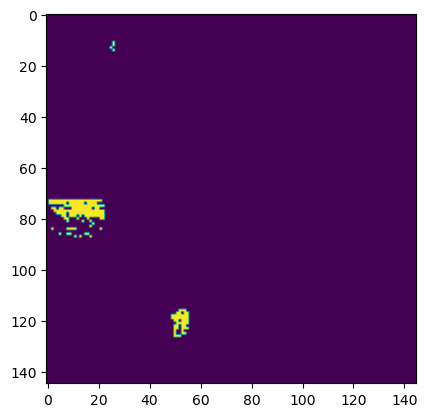

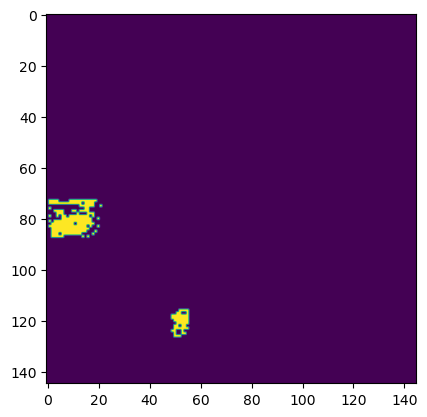

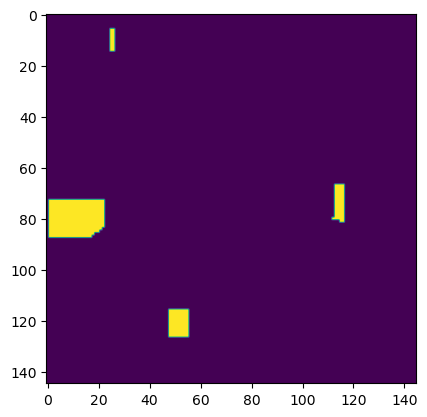

In [205]:
num = 5
plt.imshow(pseudo_labels3[:,:,num])
plt.show()
plt.imshow(pseudo_lables_orig[:,:,num])
plt.show()
plt.imshow(gt==num)
plt.show()


In [24]:
img2 = img[0::20]
gt2 = gt[0::20]
X2 = X[0::20]
Y2 = Y[0::20]
print(img2.shape)
print(np.unique(Y2))

(832, 710, 147)
[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17]


In [54]:
np.unique(Y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=uint8)

In [33]:
np.arange(0,18)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [34]:
train_gt, test_gt = sample_gt(gt2, SAMPLE_PERCENTAGE, mode='fixed')
_, pseudo_labels3 = sample_gt3(X2, Y2, train_gt, test_gt, SAMPLE_PERCENTAGE, IGNORED_LABELS, np.arange(0,18))


/home/leevi/SSL-for-HSI-classification/notebooks/../utils.py:477: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  train_gt[train_indices] = gt[train_indices]
/home/leevi/SSL-for-HSI-classification/notebooks/../utils.py:478: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  test_gt[test_indices] = gt[test_indices]


[ 1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17]
i:0
i:1000
i:2000
i:3000
i:4000
i:5000
i:6000
i:7000
i:8000
i:9000
i:10000
i:11000
i:12000
i:13000
i:14000
i:15000
i:16000
i:17000
i:18000
i:19000
i:20000
i:21000
i:22000
i:23000
i:24000
i:25000
i:26000
i:27000
i:28000
i:29000
lenEDtimesSID2: 1047,accurate:0.000000, truenum:0


In [ ]:
fig = plt.figure(figsize=(5,5))
plt.imshow(gt, aspect=0.1)
plt.colorbar()
fig.show()

In [36]:
len(np.arange(0,18))

18

In [37]:
pseudo_labels3 == pseudo_labels3

array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  Tr

In [ ]:
fig = plt.figure(figsize=(5,5))
plt.imshow(img[:,:,100], aspect=0.1)
plt.colorbar()
fig.show()

In [ ]:
for i in np.unique(gt):
    print(LABEL_VALUES[i])

In [ ]:
IGNORED_LABELS

In [11]:
LABEL_VALUES_2 = []
for i, val in enumerate(np.unique(gt)):
    if val not in IGNORED_LABELS:
        x, y = np.where(gt==val)
        for j in zip(x,y):
            gt[j[0], j[1]] = i
        x, y = np.where(Y==val)
        for j in zip(x,y):
            Y[j[0], j[1]] = i
        LABEL_VALUES_2.append(LABEL_VALUES[val])
LABEL_VALUES_2

['High intensity developed',
 'Med-low intensity developed',
 'Deciduous, Evergreen, mixed forest',
 'shrubland',
 'Grassland-Pasture',
 'Bareland',
 'water',
 'corn',
 'cereals',
 'almonds',
 'grass fodders',
 'vinewards-grapes',
 'walnuts',
 'pistachios',
 'citrus',
 'fallow']

In [12]:
train_gt, test_gt = sample_gt(gt, SAMPLE_PERCENTAGE, mode='fixed')
_, pseudo_labels3 = sample_gt3(X, Y, train_gt, test_gt, SAMPLE_PERCENTAGE)


i:0
i:1000
i:2000
i:3000
i:4000
i:5000
i:6000
i:7000
i:8000
i:9000
i:10000
i:11000
i:12000
i:13000
i:14000
i:15000
i:16000


/home/leevi/notebooks/../SSL-for-HSI-classification/utils.py:505: RuntimeWarning: invalid value encountered in subtract
  x = x - x_row_max


i:17000
i:18000
i:19000
i:20000
i:21000
i:22000
i:23000
i:24000
i:25000
i:26000
i:27000
i:28000
i:29000
i:30000
i:31000
i:32000
i:33000
i:34000
i:35000
i:36000
i:37000
i:38000
i:39000
i:40000
i:41000
i:42000
i:43000
i:44000
i:45000
i:46000
i:47000
i:48000
i:49000
i:50000
i:51000
i:52000
i:53000
i:54000
i:55000
i:56000
i:57000
i:58000
i:59000
i:60000
i:61000
i:62000
i:63000
i:64000
i:65000
i:66000
i:67000
i:68000
i:69000
i:70000
i:71000
i:72000
i:73000
i:74000
i:75000
i:76000
i:77000
i:78000
i:79000
i:80000
i:81000
i:82000
i:83000
i:84000
i:85000
i:86000
i:87000
i:88000
i:89000
i:90000
i:91000
i:92000
i:93000
i:94000
i:95000
i:96000
i:97000
i:98000
i:99000
i:100000
i:101000
i:102000
i:103000
i:104000
i:105000
i:106000
i:107000
i:108000
i:109000
i:110000
i:111000
i:112000
i:113000
i:114000
i:115000
i:116000
i:117000
i:118000
i:119000
i:120000
i:121000
i:122000
i:123000
i:124000
i:125000
i:126000
i:127000
i:128000
i:129000
i:130000
i:131000
i:132000
i:133000
i:134000
i:135000
i:136000
i:1

In [23]:
np.max(Y)

16

In [24]:
len(np.unique(Y))

17

In [17]:
62 + 27 + 5 + 96 + 421 + 161 + 2347 + 354 + 1722 + 350 + 554 + 869 + 374 + 1535 + 145 + 2496

11518

In [16]:
np.unique(train_gt, return_counts=True)

(Array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       dtype=uint8),
 array([11802882,       62,       27,        5,       96,      421,
             161,     2347,      354,     1722,      350,      554,
             869,      374,     1535,      145,     2496]))

In [ ]:
np.unique(test_gt, return_counts=True)

In [ ]:
np.unique(gt, return_counts=True)

In [ ]:
np.unique(Y, return_counts=True)

In [ ]:
_, pseudo_labels3 = sample_gt3(X, Y, train_gt, test_gt, SAMPLE_PERCENTAGE)

In [108]:
softm = softmax(16 / EDs3)
softm2 = softmax(-EDs3 * 16)
softm3 = softmax(-EDsTimesSIDs * 16*100)


/tmp/ipykernel_3454714/1497236846.py:1: RuntimeWarning: divide by zero encountered in true_divide
  softm = softmax(16 / EDs3)
/tmp/ipykernel_3454714/2521579881.py:4: RuntimeWarning: invalid value encountered in subtract
  x = x - x_row_max


In [109]:
softm3

array([0.00000000e+000, 1.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 7.24397042e-211,
       3.20194460e-177, 0.00000000e+000, 3.06502530e-284, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000])

In [102]:
softm

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan])

In [103]:
softm2

array([9.99999975e-001, 2.45170517e-008, 2.77835294e-109, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 6.42982497e-253, 4.93912647e-094,
       2.25029986e-258, 0.00000000e+000, 7.55697364e-052, 9.37087965e-220,
       0.00000000e+000, 0.00000000e+000, 4.91376113e-260, 0.00000000e+000,
       0.00000000e+000])

In [104]:
softm3

array([1.00000000e+000, 5.64121705e-032, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 4.08648095e-242,
       1.80628645e-208, 0.00000000e+000, 1.72904730e-315, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000])

In [99]:
EDs3 = EDs
EDs3[0] = 0

In [119]:
EDsTimesSIDs[0] = np.nan

In [139]:
EDsTimesSIDs3 = np.array([2.1,2,3])

In [142]:
x = -EDsTimesSIDs * 16*100

In [146]:
np.where(x!=x)

(array([0]),)

In [132]:
x = np.nan_to_num(x, nan=np.nanmin(x)*10)

In [150]:
ret = np.zeros(x.shape)
x_new = x[np.where(x==x)]
ret[np.where(x==x)] = x_new
ret

array([    0.        ,   -71.95262314,  -979.43748012, -2281.45089508,
       -1858.25904666, -2450.14391138,  -834.28707543,  -555.81790831,
        -478.34642629, -1315.7546691 ,  -724.76673373, -1270.41680063,
       -1703.85833045, -1514.87418591, -1919.96067386, -1153.55211297,
       -2996.33415447])

In [151]:
# x = np.nan_to_num(x, nan=np.nanmin(x)*10)
ret = np.zeros(x.shape)
x_new = x[np.where(x==x)]
x_row_max = np.nanmax(x_new, axis=-1)
x_row_max = x_row_max.reshape(list(x_new.shape)[:-1] + [1])
x_new = x_new - x_row_max
x_exp = np.exp(x_new)
x_exp_row_sum = x_exp.sum(axis=-1).reshape(list(x.shape)[:-1] + [1])
softmax = x_exp / x_exp_row_sum
ret[np.where(x==x)] = softmax
ret

array([0.00000000e+000, 1.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 7.24397042e-211,
       3.20194460e-177, 0.00000000e+000, 3.06502530e-284, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000])

In [152]:
softmax

array([1.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 7.24397042e-211, 3.20194460e-177,
       0.00000000e+000, 3.06502530e-284, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000])

In [206]:

label_values = ['Undefined',
                'High intensity developed', 
                'Med-low intensity developed',
                'Deciduous, Evergreen, mixed forest',
                'shrubland',
                'Grassland-Pasture',
                'Bareland',
                'water',
                'corn',
                'cotton',
                'cereals',
                'almonds',
                'grass fodders',
                'vinewards-grapes',
                'walnuts',
                'pistachios',
                'citrus',
                'fallow']
all_labels = np.arange(len(label_values))
print(len(all_labels))
print(len(label_values))

18
18


In [207]:
all_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [208]:
np.arange(0,18)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])